In [1]:
# get datasetd from "geometry of truth paper"
!git clone https://github.com/saprmarks/geometry-of-truth.git /root/geometry-of-truth
!mv /root/geometry-of-truth/datasets/*.csv data

Cloning into '/root/geometry-of-truth'...


remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 273 (delta 55), reused 59 (delta 45), pack-reused 195
Receiving objects: 100% (273/273), 71.49 MiB | 6.87 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (52/52), done.


In [2]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [3]:
# import my modules
import importlib
# join the path to the modules to the current working directory
\
import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [4]:
# iterate through all csv files in data folder
for file in os.listdir('data'):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv('data/'+file)
    print('\n','#'*10, file, '#'*10)
    # print column names
    print(df.columns)


 ########## cities.csv ##########
Index(['statement', 'label', 'city', 'country', 'correct_country'], dtype='object')

 ########## cities_cities_conj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## cities_cities_disj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## common_claim.csv ##########
Index(['Unnamed: 0', 'examples', 'label', 'agreement'], dtype='object')

 ########## common_claim_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## companies_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## counterfact_true_false.csv ##########
Index(['statement', 'label', 'relation


 ########## geonames.csv ##########
Index(['Geoname ID', 'Name', 'ASCII Name', 'Alternate Names', 'Feature Class',
       'Feature Code', 'Country Code', 'Country name EN', 'Country Code 2',
       'Admin1 Code', 'Admin2 Code', 'Admin3 Code', 'Admin4 Code',
       'Population', 'Elevation', 'DIgital Elevation Model', 'Timezone',
       'Modification date', 'LABEL EN', 'Coordinates'],
      dtype='object')

 ########## larger_than.csv ##########
Index(['statement', 'label', 'n1', 'n2', 'diff', 'abs_diff'], dtype='object')

 ########## likely.csv ##########
Index(['statement', 'label', 'likelihood'], dtype='object')

 ########## likely_old.csv ##########
Index(['statement', 'label', 'likelihood'], dtype='object')

 ########## neg_cities.csv ##########
Index(['statement', 'label', 'city', 'country', 'correct_country'], dtype='object')

 ########## neg_sp_en_trans.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## smaller_than.csv ##########
Index(['statement', 'lab

In [5]:
dataset_name = "cities"
df = pd.read_csv('data/'+dataset_name+'.csv')

train_dataset = {'dataset_name': dataset_name,
           'org_data': list(df.statement),
           'label': list(df.label)}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision = torch.float16
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
os.makedirs(plots_folder, exist_ok=True)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    # get access token from environment variable
    access_token = os.getenv("HF_TOKEN")
    if not access_token:
        access_token = input("Please set the HF_TOKEN environment variable to your Hugging Face access token.")
    # access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=precision, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id


batch_size = 64
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [7]:
torch.cuda.empty_cache()
# get internal activations

token_positions = -1
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
train_dataset['hidden_states'] = get_hidden(model, tokenizer, module_names, train_dataset['org_data'], batch_size=batch_size, token_position=-1)

100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


In [8]:
train_dataset['hidden_states'].shape

torch.Size([32, 1496, 4096])

In [9]:
train_data, test_data, train_labels, test_labels = prep_data(train_dataset['hidden_states'], train_dataset['label'], train_perc=0.8)
train_data.shape, test_data.shape

(torch.Size([32, 1196, 4096]), torch.Size([32, 300, 4096]))

In [10]:
# training probes
probes = {}
for idx, module in tqdm(enumerate(module_names), total=num_modules):
    probes[module] = LRProbe(d_in=model.config.hidden_size, device='cuda', dtype=torch.float32)
    probes[module].train(train_data[idx], train_labels, epochs=2, batch_size=batch_size)

# test on same dataset
test_accs = {}
train_accs = {}
for idx, module in enumerate(module_names):
    test_accs[module] = probes[module].test(test_data[idx], test_labels)
    train_accs[module] = probes[module].test(train_data[idx], train_labels)

100%|██████████| 32/32 [00:05<00:00,  6.34it/s]


In [11]:
# print every 5th test acc:
for index, (key, value) in enumerate(test_accs.items()):
    if index % 5 == 0:
        print(f'{key}\t{value:.2g}') 

model.layers.0	0.45
model.layers.5	0.91
model.layers.10	1
model.layers.15	1
model.layers.20	0.99
model.layers.25	0.99
model.layers.30	0.99


In [12]:
def test_probes(probes, test_data, test_labels, module_names, normalize=True):
    if normalize:
        # calc statistics over samples and token positions
        mean_test = test_data.mean([1, 2], keepdim=True)
        std_test = test_data.std([1, 2], keepdim=True)
        test_data = (test_data - mean_test)/std_test

    test_accs_ood = {}
    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        test_accs_ood[module] = {}
        for token_pos in range(test_data.shape[2]):
            test_accs_ood[module][token_pos] = probes[module].test(test_data[idx,:,token_pos, :], test_labels)

    return test_accs_ood

def plot_test_accs(test_accs, positions, train_dataset_name, test_dataset_name):
    # plot test accs for ood dataset
    plt.figure(figsize=(10, 6))

    for pos, label in positions.items():
        plt.plot([acc[pos] for _,acc in test_accs.items()], label=label)
    plt.ylabel('Accuracy')
    plt.xlabel('Layer')
    plt.grid()
    plt.legend()
    plt.title(f"LogRegr trained on \"{train_dataset_name}\", tested on \"{test_dataset_name}\"")
    plt.savefig(f"{plots_folder}/log_regr_trained_{train_dataset_name}_tested_{test_dataset_name}.png")
    plt.show()

In [13]:
# test on out of distribution dataset

max_new_tokens = 10
test_dataset_name = 'Statements1000'

# load dataset
test_dataset = load_data_set(test_dataset_name)
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"
    change_format(test_dataset, lie_format, truth_format)

print('\nGenerating truths and lies')
get_overlap_truth_lies(model, tokenizer, test_dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)
# get hidden states for the new dataset



Generating truths and lies
Size of dataset Statements1000: 1012


16it [00:19,  1.20s/it]                        
16it [00:00, 500.88it/s]              


Success rate when generating truths: 76.68%


16it [00:18,  1.13s/it]                        
16it [00:00, 519.02it/s]              

Success rate when generating lies:   60.28%
Overlap: 42.29%


In [ ]:
token_positions = range(-max_new_tokens-1, 0, 1)

print('\nCalculating hidden states')
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
test_dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, test_dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
test_dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, test_dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


In [ ]:
print('\nTesting probes')
samples_per_class = test_dataset['hidden_states_lie'].shape[1]
test_labels = torch.cat([torch.zeros(samples_per_class), torch.ones(samples_per_class)])
test_data=torch.cat([test_dataset['hidden_states_lie'], test_dataset['hidden_states_truth']], dim=1)
test_accs_ood = test_probes(probes, test_data=test_data, test_labels=test_labels, module_names=module_names)

# save results
plot_test_accs(test_accs_ood, positions={0:'last statement token', 1:'1st answer token', 2:'2nd answer token', 3:'3rd answer token', max_new_tokens:'last answer token'}, 
            train_dataset_name = train_dataset['dataset_name'], 
            test_dataset_name = test_dataset['dataset_name'])

In [ ]:
def test_probes_formats(format_sentence, probes, model, tokenizer, module_names, mean_test, std_test, device='cuda'):
    inputs = tokenizer(format_sentence, return_tensors="pt").to(model.device)
    token_positions = range(inputs['input_ids'].shape[1])
    hidden_states = get_hidden_from_tokens(model, module_names, inputs, token_position=token_positions)
    print(hidden_states.shape)

    # normalize
    hidden_states -= mean_test
    hidden_states /= std_test

    hidden_states = hidden_states.to(device=device, dtype=torch.float32)
    decoded = []
    for idx, input_id in enumerate(inputs['input_ids'][0]):
        decoded.append(tokenizer.decode(input_id))


    test_accs_formats = {}
    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        test_accs_formats[module] = {}
        for token_pos in token_positions:
            test_accs_formats[module][token_pos] = probes[module].forward(hidden_states[idx,:,token_pos, :]).detach().cpu().numpy()

    return test_accs_formats, decoded

def calc_averages(test_accs_formats, decoded, average_over=3):
    pos_dict = {}
    ctr =0
    averaged_accs = {}
    for m, accs in test_accs_formats.items():
        ctr =0
        averaged_accs[m] = {}
        sum_ctr = 0
        sum = 0
        for k, acc in accs.items():
            sum += acc
            sum_ctr += 1
            if sum_ctr == average_over or k==list(accs.keys())[-1]:            
                averaged_accs[m][ctr]=sum/average_over
                sum = 0
                sum_ctr = 0
                ctr+=1
    ctr = 0
    for i in range(0, len(decoded), average_over):
        pos_dict[ctr] = ', '.join(decoded[i:i+average_over])
        ctr += 1


    return pos_dict, averaged_accs

# get mean and std
average_over = 3
mean_test = test_data.mean([1, 2], keepdim=True)
std_test = test_data.std([1, 2], keepdim=True)

test_accs_formats, decoded = test_probes_formats(format_sentence=test_dataset['truth_format'].format(''), 
                    probes=probes, model=model, tokenizer=tokenizer, 
                    module_names=module_names, mean_test=mean_test, std_test=std_test, device='cuda')
print(f'format: "{test_dataset["truth_format"].format("")}"')
print(f"tokens: {decoded}")

pos_dict, averaged_accs = calc_averages(test_accs_formats, decoded, average_over=average_over)


plot_test_accs(averaged_accs, positions=pos_dict, 
               train_dataset_name = train_dataset['dataset_name'], 
               test_dataset_name = test_dataset['dataset_name']+'_truth_format')

test_accs_formats, decoded = test_probes_formats(format_sentence=test_dataset['lie_format'].format(''),
                                                probes=probes, model=model, tokenizer=tokenizer, 
                                                module_names=module_names, mean_test=mean_test, std_test=std_test, device='cuda')
print(f'format: "{test_dataset["truth_format"].format("")}"')
print(f"tokens: {decoded}")

pos_dict, averaged_accs = calc_averages(test_accs_formats, decoded, average_over=average_over)
plot_test_accs(averaged_accs, positions=pos_dict, 
               train_dataset_name = train_dataset['dataset_name'], 
               test_dataset_name = test_dataset['dataset_name']+'_lie_format')

# evolution of acc over all tokens

In [33]:
attention_mask_lie = test_dataset['output_tokens_lie']['attention_mask']
attention_mask_truth = test_dataset['output_tokens_truth']['attention_mask']

max_num_tokens_lie = attention_mask_lie.shape[1]
max_num_tokens_truth = attention_mask_truth.shape[1]
num_samples = attention_mask_lie.shape[0]
hidden_dim = model.config.hidden_size
max_num_tokens_lie, max_num_tokens_truth


(62, 60)

In [34]:
attention_mask_lie.shape

torch.Size([428, 62])

In [35]:
max_tokens = max(max_num_tokens_lie, max_num_tokens_truth)
start_lie = max_tokens - max_num_tokens_lie
start_truth = max_tokens - max_num_tokens_truth

# the hidden states are quite large, so we need to split them into smaller batches
half_batch_size = 32

In [36]:
max_tokens

62

In [37]:
token_positions_lie

range(0, 62)

In [ ]:
print('\nCalculating hidden states')
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
normalize = True
# i iterate from the back as i use left padding and tokens of lying and truth telling are aligned at the end
probe_output = torch.zeros([num_modules, num_samples*2, max_tokens], device='cpu', dtype=torch.float32)*torch.Tensor([float('nan')])
test_accs = torch.zeros([num_modules, num_samples*2, max_tokens], device='cpu', dtype=torch.float32)*torch.Tensor([float('nan')])
for i, j in zip(range(0, num_samples, half_batch_size), range(0, 2*num_samples, 2*half_batch_size)):


    this_batch_size = min(half_batch_size, num_samples-i)

    # indices for combined batch
    start_full = j
    end_full = j+this_batch_size*2

    hidden_states = torch.zeros([num_modules, this_batch_size*2, max_tokens, hidden_dim], device='cpu', dtype=precision)
    attention_mask = torch.zeros([this_batch_size*2, max_tokens], device='cpu', dtype=attention_mask_lie.dtype)

    token_positions_lie = range(max_num_tokens_lie)
    data = {'input_ids': test_dataset['output_tokens_lie']['input_ids'][i:i+this_batch_size],
            'attention_mask': test_dataset['output_tokens_lie']['attention_mask'][i:i+this_batch_size]}
    temp_hidden = get_hidden_from_tokens(model, module_names, data, batch_size=batch_size, token_position=token_positions_lie)
    attention_mask[:this_batch_size, start_lie:max_tokens] = data['attention_mask']

    # set values where attention is zero to nan
    hidden_states[:, :this_batch_size, start_lie:max_tokens, :] = temp_hidden

    token_positions_truth = range(max_num_tokens_truth)
    data = {'input_ids': test_dataset['output_tokens_truth']['input_ids'][i:i+this_batch_size],
            'attention_mask': test_dataset['output_tokens_truth']['attention_mask'][i:i+this_batch_size]}
    temp_hidden = get_hidden_from_tokens(model, module_names, data, batch_size=batch_size, token_position=token_positions_truth)
    temp_attention = (attention_mask_truth[i:i+this_batch_size, :][None, :, :, None]==1)
    hidden_states[:, this_batch_size:, start_truth:max_tokens, :] = temp_hidden
    attention_mask[this_batch_size:, start_truth:max_tokens] = data['attention_mask']
    test_labels = torch.cat([torch.zeros(this_batch_size), torch.ones(this_batch_size)])


    if normalize:
        # TODO!!!
        # I should still somehow normalize
        # there are a lot of repeated tokens in the beginning 
        # (like all the instructions are exactly the same, if i take the mean over all the tokens, it is going to be heavily biased)
        # calc statistics over samples and token positions
        # calc mean over hidden states only for values where attention is not zero
        temp_hidden = torch.where(condition=attention_mask[None, :, :, None]==1, input=hidden_states, other=torch.Tensor([float('nan')]))
        # mean_test = temp_hidden.nanmean([1, 2], keepdim=True)
        # std_test = temp_hidden.nanmean([1, 2], keepdim=True)
        # hidden_states = (hidden_states - mean_test)/std_test

    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        probe = probes[module]
        probe.net.eval()
        for token_pos in range(hidden_states.shape[2]):
            with torch.no_grad():
                acts_batch = hidden_states[idx, :, token_pos].to(device=probe.device, dtype=probe.dtype)
                probe_output[idx, start_full:end_full, token_pos] = probe.forward(acts_batch).detach().cpu()

    test_accs[:, start_full:end_full, :] = (probe_output[:, start_full:end_full, :]>0.5)==test_labels[None, :, None]

    # set accs to nan where attention is zero
    test_accs[:, start_full:end_full, :] = torch.where(condition=attention_mask[None, :, :]==1,
                                                         input=test_accs[:, start_full:end_full, :],
                                                            other=torch.Tensor([float('nan')]))
                                                         
    probe_output[:, start_full:end_full, :] = torch.where(condition=attention_mask[None, :, :]==1, 
                                                                input=probe_output[:, start_full:end_full, :], 
                                                                other=torch.Tensor([float('nan')]))


In [75]:
test_accs.shape

torch.Size([32, 856, 62])

In [68]:
mean_test_acc = test_accs.nanmean(dim=1)

non_nans = torch.sum(~torch.isnan(test_accs), dim=1)[0]

In [70]:
non_nans

tensor([  0,   0,   0,   0,   1,   4,   6,  10,  12,  16,  22,  30,  39,  55,
         79, 113, 194, 269, 403, 522, 643, 735, 794, 831, 847, 853, 850, 846,
        846, 848, 834, 816, 810, 734, 752, 710, 722, 760, 802, 826, 844, 854,
        856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 853,
        848, 845, 843, 841, 839, 837])

In [85]:
min_non_nans = int(num_samples*2*0.6)
# plot mean test accs
mean_test_acc = mean_test_acc[:, non_nans>min_non_nans]

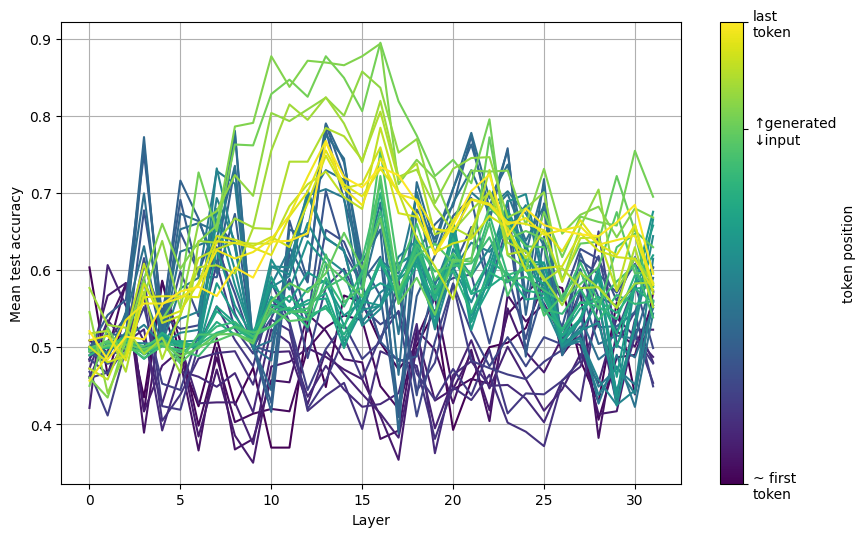

In [95]:
colors = matplotlib.cm.viridis(np.linspace(0, 1, mean_test_acc.shape[1]))  # Color map
x = range(0, num_modules)
fig, ax = plt.subplots(figsize=(10, 6))  # Define a figure and axes explicitlyx = range(0, num_modules)
for i in range(mean_test_acc.shape[1]):
    ax.plot(x, mean_test_acc[:, i], color=colors[i])

ax.grid()
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=mean_test_acc.shape[1]))
sm.set_array([])  # You need this line even though it's counterintuitive (sets up the ScalarMappable correctly)
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='token position')
cbar.set_ticks([0, mean_test_acc.shape[1]-10, mean_test_acc.shape[1]])  # Set ticks at the start and end
cbar.set_ticklabels(['~ first\ntoken', '\u2191generated\n\u2193input', 'last\ntoken'])  # Label for each tick
ax.set_ylabel('Mean test accuracy')
ax.set_xlabel('Layer')
plt.savefig(f"{plots_folder}/mean_test_accs_all_tokens.png")
plt.show()